## Analyze clusters among anomalies
The clustering approach can help to gain insight into the model by grouping the anomalous spectra into clusters based on their similarity in terms of the weights assigned by the LIME algorithm. This can help identify patterns or trends in the explanations that may not be immediately apparent from the weights alone.

For example, certain clusters might have higher explanation weights for certain wavelength ranges, or certain clusters have higher explanation weights overall. This can help to understand which features of the spectra are most important for the model's predictions, and can potentially uncover new scientific insights.

Additionally, by plotting the mean spectrum and mean explanation weights for each cluster, I can get a sense of how the model is using different features of the spectra to make its predictions, and identify any patterns or trends in the model's behavior that may be relevant to the anomaly detection task.

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES

In [2]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"

model = "256_128_64/latent_12"

iml_use_case_directory = (
    f"{user}/explain-me-why/sections/figures/iml_use_cases"
)

region_of_interest = "weights_all_abs"
region_directory = (
    f"{iml_use_case_directory}/cluster_regions_of_interest/"
    f"{region_of_interest}"
)

# metric = "mse_filter_250kms_noRel97"
metric = "mse_noRel100"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/explanation/"
    f"{model}/{metric}"
)

In [3]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")

anomalies = np.load(f"{data_directory}/top_anomalies.npy")

df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)
# load the weights
explanation_weights = np.load(
    f"{data_directory}/explanation_weights/weights_all_abs_"
    f"smooth_True_drop_0.05_{metric}_bin_03.npy"
)

explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

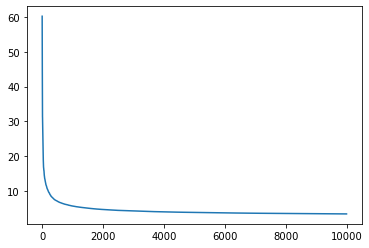

In [4]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies array as well
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

# Inspect spectra in clusters

In [5]:
# load the Kmeans model
head_model_name = "kmeans"
# head_model_name = "kmeans_"
# head_model_name = "kmeans_"
# head_model_name = "kmeans_"
# head_model_name = "kmeans_"

if metric == "mse_filter_250kms_noRel97":

    metric_name = "MSE ($250$ km s$^{-1}$, ignore $3\%$)"
    metric_directory = "filter_mse"

    model_name = (
        f"{head_model_name}_mse_filter_250kms_noRel97_bin_03.pkl"
    )

elif metric == "mse_noRel100":

    metric_name = "MSE"
    metric_directory = "mse"

    model_name = (
        f"{head_model_name}_mse_noRel100_bin_03.pkl"
    )

print(model_name)

with open(f"{region_directory}/{model_name}", "rb") as f:
    kmeans = pickle.load(f)

kmeans_mse_noRel100_bin_03.pkl


## Get spectra and explanation weights per cluster

In [6]:
# set dictionary with np.array of anomalies and explanaion weights
# per cluster label

cluster_labels = kmeans.labels_
unique_cluster_labels = np.unique(cluster_labels)

spectra_in_cluster = {}
weights_in_cluster = {}

for cluster_label in unique_cluster_labels:


    cluster_mask = cluster_labels == cluster_label

    spectra_in_cluster[cluster_label + 1] = anomalies[cluster_mask]


    weights_in_cluster[cluster_label + 1] = explanation_weights[
        cluster_mask
    ]
    
    # print(f"Cluster: {cluster_label}")
    # print(f"N. spectra: {spectra_in_cluster[cluster_label + 1].shape}")
    # print(f"N. weights: {weights_in_cluster[cluster_label + 1].shape}")


In [7]:
# get indices of closes data points to centroids
centroids = kmeans.cluster_centers_
idx_closest_to_centroid = {}

for label, cluster in weights_in_cluster.items():

    cluster_centroid = centroids[label - 1].reshape(1, -1)

    distances = np.sum((cluster - cluster_centroid)**2, axis=1)

    idx_closest = np.argsort(distances)[:5]

    idx_closest_to_centroid[label] = idx_closest

In [8]:
save_directory = (
    f"{region_directory}/{metric_directory}/closes_to_centroid"
)
if os.path.exists(save_directory) is False:
    os.makedirs(save_directory)


for label, idx_closest in idx_closest_to_centroid.items():

    for idx, centroid_index in enumerate(idx_closest):

        fig, axs = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=None,
            sharex=True,
            sharey=False,
            tight_layout=True,
        )
        # clear the axes for next plot
        # for ax in axs.flatten(): ax.clear()
        # clear figure for next plot
        # fig.clear()

        print(
            f"Cluster centroid index: {centroid_index} "
            f"cluster label: {label}"
        )

        # add title 
        fig.suptitle(
            f"[{idx +1}] Closest spectra to centroid of cluster {label}."
            f"\nmetric: {metric_name}",
            fontsize=12,
        )
        # set minor ticks on
        for ax in axs.flatten(): ax.minorticks_on()

        # plot spectra and explanation weights of centroid

        spectrum_close = spectra_in_cluster[label][centroid_index]
        axs[0].plot(wave, spectrum_close, color="black")

        weights_close = weights_in_cluster[label][centroid_index]
        axs[1].plot(wave, weights_close, color="black")

        axs[0].set_ylabel("Normalized flux")
        axs[1].set_ylabel("Explanation weights")
        axs[1].set_xlabel("$\lambda$ [\AA]")
        axs[1].set_ylim(0., 1.)

        fig.savefig(
            f"{save_directory}/"
            f"{idx +1}_centroid_spectra_cluster_{label}.pdf"
        )

        # close the figure
        plt.close(fig)

Cluster centroid index: 2260 cluster label: 1
Cluster centroid index: 3958 cluster label: 1
Cluster centroid index: 369 cluster label: 1
Cluster centroid index: 2555 cluster label: 1
Cluster centroid index: 2561 cluster label: 1
Cluster centroid index: 767 cluster label: 2
Cluster centroid index: 355 cluster label: 2
Cluster centroid index: 103 cluster label: 2
Cluster centroid index: 95 cluster label: 2
Cluster centroid index: 450 cluster label: 2
Cluster centroid index: 292 cluster label: 3
Cluster centroid index: 497 cluster label: 3
Cluster centroid index: 158 cluster label: 3
Cluster centroid index: 269 cluster label: 3
Cluster centroid index: 362 cluster label: 3
Cluster centroid index: 212 cluster label: 4
Cluster centroid index: 375 cluster label: 4
Cluster centroid index: 710 cluster label: 4
Cluster centroid index: 118 cluster label: 4
Cluster centroid index: 397 cluster label: 4
Cluster centroid index: 811 cluster label: 5
Cluster centroid index: 135 cluster label: 5
Cluster